Neuroimaging image reconstruction from Cartesian data
==============================================

In this tutorial we will reconstruct an MRI image from Cartesian under-sampled kspace measurements.

We use the toy datasets available in pysap, more specifically a 2D brain slice
and the cartesian acquisition scheme.
We compare zero-order image reconstruction with Compressed sensing reconstructions (analysis vs synthesis formulation) using the FISTA algorithm for the synthesis formulation and the Condat-Vu algorithm for the analysis formulation

Author: Chaithya G R & Philippe Ciuciu
Date: 01/05/2021 


In [26]:
# Package import
from modopt.math.metrics import ssim
#from mri.numerics.fourier import FFT2
#from mri.numerics.reconstruct import sparse_rec_condatvu, sparse_rec_fista
#from mri.numerics.utils import generate_operators
#from mri.numerics.utils import convert_mask_to_locations

from mri.operators import FFT, WaveletN, WaveletUD2
from mri.operators.utils import convert_mask_to_locations
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data

# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold
import numpy as np
import matplotlib.pyplot as plt

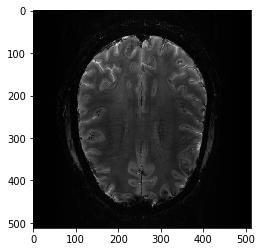

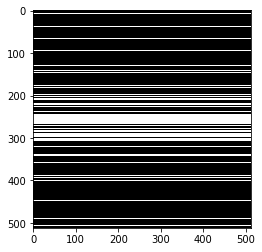

In [12]:
# Loading input data
image = get_sample_data('2d-mri')

# Obtain K-Space Cartesian Mask
mask = get_sample_data("cartesian-mri-mask")


# View Input
plt.figure()
plt.imshow(image, cmap='gray')
plt.figure()
plt.imshow(mask, cmap='gray')
plt.show()

Generate the kspace
-------------------

From the 2D brain slice and the acquisition mask, we retrospectively
undersample the k-space using a cartesian acquisition mask
We then reconstruct the zero order solution as a baseline

Get the locations of the kspace samples

In [14]:
#kspace_loc = convert_mask_to_locations(np.fft.fftshift(mask.data))
# Generate the subsampled kspace
#fourier_op = FFT2(samples=kspace_loc, shape=image.shape)
#kspace_data = fourier_op.op(image)

kspace_loc = convert_mask_to_locations(mask.data)
fourier_op = FFT(samples=kspace_loc, shape=image.shape)
kspace_data = fourier_op.op(image)

/home/ciuciu/work/code/git/pysap-mri/mri/operators/fourier/utils.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


Zero order solution

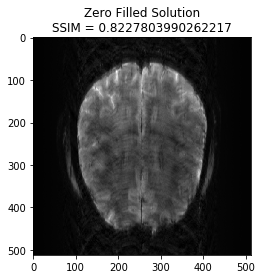

In [16]:
image_rec0 = pysap.Image(data=fourier_op.adj_op(kspace_data),
                         metadata=image.metadata)
plt.imshow(np.abs(image_rec0), cmap='gray')
# Calculate SSIM
base_ssim = ssim(image_rec0, image)
plt.title('Zero Filled Solution\nSSIM = ' + str(base_ssim))
plt.show()


Synthesis formulation: FISTA optimization
------------------------------------------------------------

We now want to refine the zero order solution using a FISTA optimization.
The cost function is set to Proximity Cost + Gradient Cost

In [17]:
linear_op = WaveletN(wavelet_name="sym8", nb_scales=4)
regularizer_op = SparseThreshold(Identity(), 2 * 1e-7, thresh_type="soft")

reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Lipschitz constant is 1.1000000000000558
The lipschitz constraint is satisfied


N/A% (0 of 200) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

 - mu:  2e-07
 - lipschitz constant:  1.1000000000000558
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7f470638fdd0> - 4
 - max iterations:  200
 - image variable shape:  (512, 512)
 - alpha variable shape:  (291721,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  64.62713299999999  seconds
----------------------------------------


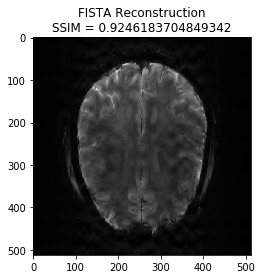

In [18]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_data,
    optimization_alg='fista',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('FISTA Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()

#gradient_op, linear_op, prox_op, cost_op = generate_operators(
#    data=kspace_data,
#    wavelet_name="sym8",
#    samples=kspace_loc,
#    nb_scales=4,
#    mu=8 * 1e-7,
#    non_cartesian=False,
#    uniform_data_shape=None,
#    gradient_space="analysis",
#    padding_mode="periodization")

Analysis formulation: Condat-Vu reconstruction 
---------------------------------------------------------------------

In [22]:
linear_op = WaveletUD2(
    wavelet_id=24,
    nb_scale=4,
)

In [23]:
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)

Lipschitz constant is 1.1
The lipschitz constraint is satisfied


 - mu:  2e-07
 - lipschitz constant:  1.1
 - tau:  0.937465492611657
 - sigma:  0.5
 - rho:  1.0
 - std:  None
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletUD2 object at 0x7f47407f4b50> - 4
 - max iterations:  200
 - number of reweights:  0
 - primal variable shape:  (512, 512)
 - dual variable shape:  (2621440,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:03:40 Time:  0:03:40


 - final iteration number:  200
 - final cost value:  1000000.0
 - converged:  False
Done.
Execution time:  894.429451  seconds
----------------------------------------


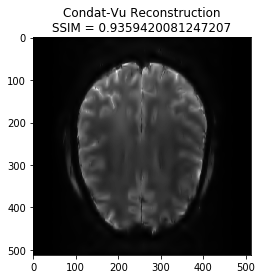

In [24]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_data,
    optimization_alg='condatvu',
    num_iterations=200,
)
image_rec = pysap.Image(data=np.abs(x_final))
plt.imshow(np.abs(image_rec), cmap='gray')
recon_ssim = ssim(image_rec, image)
plt.title('Condat-Vu Reconstruction\nSSIM = ' + str(recon_ssim))
plt.show()
